# 산탄데르 은행의 고객 만족도 데이터 분석

### 1. 필요 라이브러리 import

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### 2. Data load 후 확인

In [4]:
# data load
df = pd.read_csv('/content/train.csv')

In [5]:
# data 확인
df.head(10)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.00,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91.56,138.84,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,40501.08,13501.47,0.0,0.0,0.0,0.0,0.0,0.0,85501.89,85501.89,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
5,13,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87975.750000,0
6,14,2,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.00,2.13,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94956.660000,0
7,18,2,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.00,2.94,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,251638.950000,0
8,20,2,45,0.0,0.0,0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [7]:
# column : var3에 -999999값 존재
# 다른 column에도 -999999가 있을까?
# 데이터가 많이 sparse함

df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182

In [22]:
# 결측치 확인
df.isnull().sum().any()

False

In [9]:
# Costomer happy : 0
# Costomer unhappy : 1
# The percentage of unhappy customer : 4% (= 3008 / 76020)
print(df['TARGET'].value_counts())
print((df['TARGET'].sum() / len(df['TARGET'])*100).round(2))

# df.iloc[:, 1:].value_counts(normalize=True)

0    73012
1     3008
Name: TARGET, dtype: int64
3.96


### 3. Feature selection

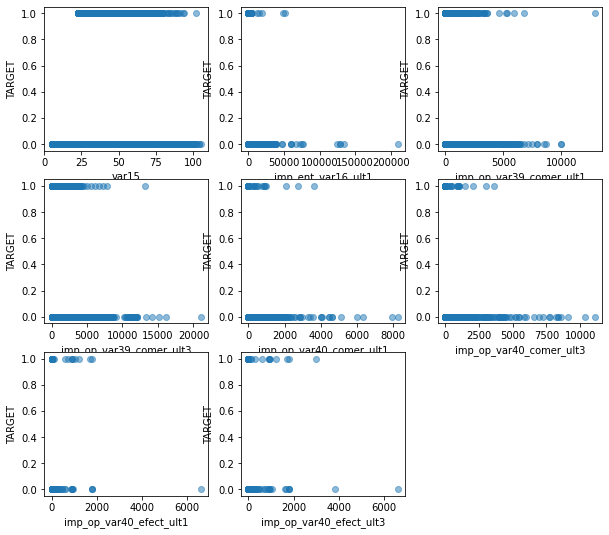

In [10]:
# 데이터의 feature가 많고 익명화되어있어 어떤 feature가 target과 관계있을지 유추하기 쉽지 않음
# 10개정도 feature와 target 사이의 상관관계를 시각화 해보면 유의미한 feature도 있고 아닌것 같이 보이는 feature도 있음
# 버리기엔 feature 개수에 비해 데이터가 너무 적어 혹시 underfitting이 될까봐 최대한 가져가고자 함
# 한편으로는 sparse한 data라 관련 없어 보이는 feature는 과감하게 drop하는건 어땠을까

plt.figure(figsize=(10,9))
for i in range(2, 10):
    plt.subplot(3, 3, i-1)
    X = df[df.columns[i]]
    Y = df['TARGET']
    plt.scatter(X, Y, alpha=0.5)
    plt.xlabel(f'{df.columns[i]}')
    plt.ylabel('TARGET')
plt.tight_layout()
plt.show()

### 4. Data preprocessing (데이터 전처리)

In [11]:
# -999999값 존재 확인, 총 116개
for i in range(1, 3):
  print(df.columns[i], df.iloc[:, i].value_counts(), '',sep='\n')

var3
 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: var3, Length: 208, dtype: int64

var15
23     20170
24      6232
25      4217
26      3270
27      2861
       ...  
97         3
104        2
98         1
105        1
101        1
Name: var15, Length: 100, dtype: int64



In [12]:
print(df['var3'].describe())

count     76020.000000
mean      -1523.199277
std       39033.462364
min     -999999.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         238.000000
Name: var3, dtype: float64


In [13]:
##
df[df.iloc[:,:] == -999999].sum()

ID                                 0.0
var3                      -115999884.0
var15                              0.0
imp_ent_var16_ult1                 0.0
imp_op_var39_comer_ult1            0.0
                              ...     
saldo_medio_var44_hace3            0.0
saldo_medio_var44_ult1             0.0
saldo_medio_var44_ult3             0.0
var38                              0.0
TARGET                             0.0
Length: 371, dtype: float64

In [14]:
# 결측값 처리 (mode, 최빈값 2로)
df[df.iloc[:,:] == -999999].replace(-999999, 2, inplace=True)

# data는 X, target은 Y로 분류 
X = df.drop(['ID', 'TARGET'], axis=1)
Y = df['TARGET']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

### 5. Model selection (모델 선택)

In [15]:
# XGBoost
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

# (추가로 KNN, SVM 같이 거리를 사용하는 model들은 data를 표준화 해줘야 함)
# KNN
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

# Random Forest
rf = RandomForestClassifier(max_depth=5, n_estimators=100)
rf.fit(x_train, y_train)

# SVM
# svc = SVC(probability=True)
# svc.fit(x_train, y_train)


RandomForestClassifier(max_depth=5)

### Hyperparameter Tuning

In [16]:
# # hyperparameter tuning

# params = {'max_depth':[5, 6, 7],
#           'min_child_weight':[1, 2 ,3],
#           'colsample_bytree':[0.5, 0.75, 1],
#           'gamma':[0.1, 0.5]}

# grid = GridSearchCV(xgb, param_grid=params, cv=3, refit=True)
# grid.fit(x_train, y_train)

# print("Best parameter = ", grid.best_params_)


### 결과 프린트

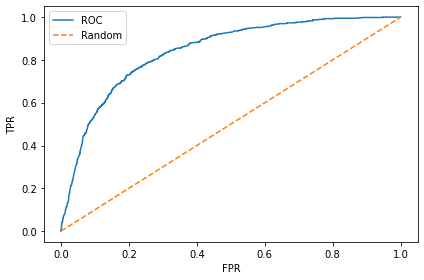

roc auc score of XGBClassifier(): 0.8409


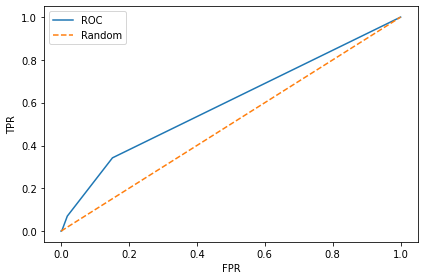

roc auc score of KNeighborsClassifier(): 0.5975


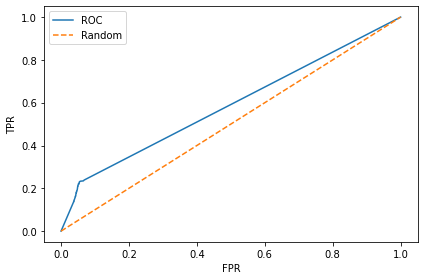

roc auc score of DecisionTreeClassifier(): 0.5861


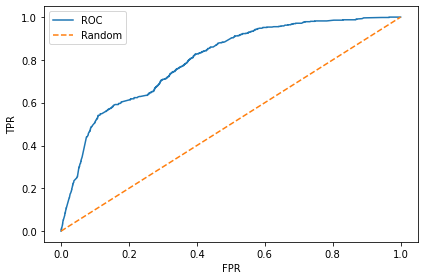

roc auc score of RandomForestClassifier(max_depth=5): 0.7991


In [17]:
models = [xgb, knn, dt, rf]

for i in models:
  # ROC curve 및 AUC 계산
  y_prob = i.predict_proba(x_test)[:, 1]

  # ROC curve
  fprs, tprs, thresholds = roc_curve(y_test, y_prob)

  plt.plot(fprs, tprs, label = 'ROC')
  plt.plot([0,1], [0,1], '--', label = 'Random')
  plt.legend()
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.tight_layout()
  plt.show()

  # AUC 계산
  print(f'roc auc score of {i}: {roc_auc_score(y_test, y_prob):.4f}')

In [18]:
# 평가
y_test_prob = xgb.predict_proba(x_test)[:, 1]
y_train_prob = xgb.predict_proba(x_train)[:, 1]
print(f'roc auc score(test_data): {roc_auc_score(y_test, y_test_prob):.4f}')
print(f'roc auc score(train_data): {roc_auc_score(y_train, y_train_prob):.4f}')

roc auc score(test_data): 0.8409
roc auc score(train_data): 0.8556
